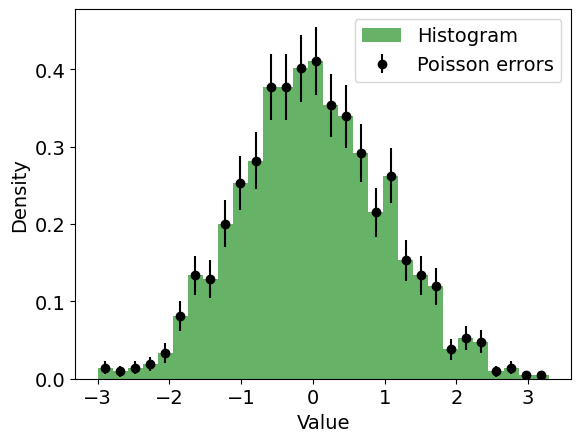

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some example data
data = np.random.normal(size=1000)

# Create the histogram with density=False to get the counts and bin edges
counts, bin_edges = np.histogram(data, bins=30)

# Calculate the width of each bin
bin_widths = np.diff(bin_edges)

# Calculate the Poisson errors
poisson_errors = np.sqrt(counts)

# Normalize the counts and errors to get the density
density = counts / (counts.sum() * bin_widths)
density_errors = poisson_errors / (counts.sum() * bin_widths)

# Plot the histogram with density=True
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Histogram')

# Calculate the bin centers for plotting error bars
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot the error bars
plt.errorbar(bin_centers, density, yerr=density_errors, fmt='o', color='black', label='Poisson errors')

plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

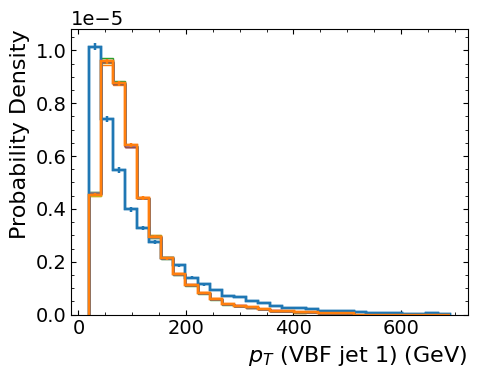

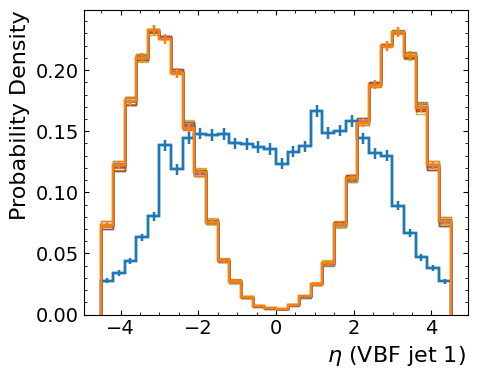

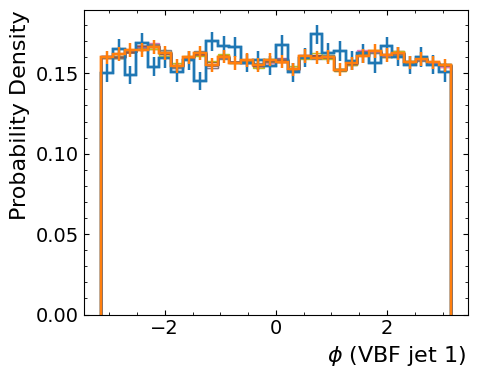

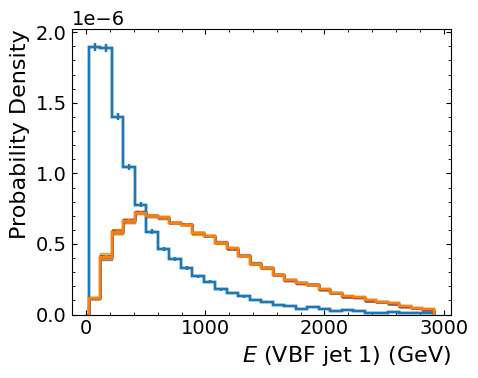

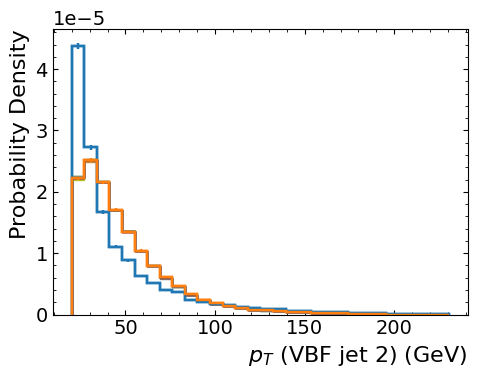

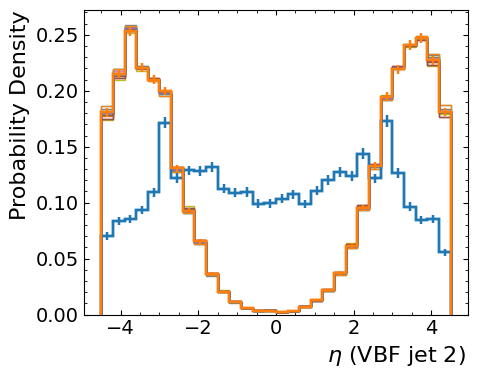

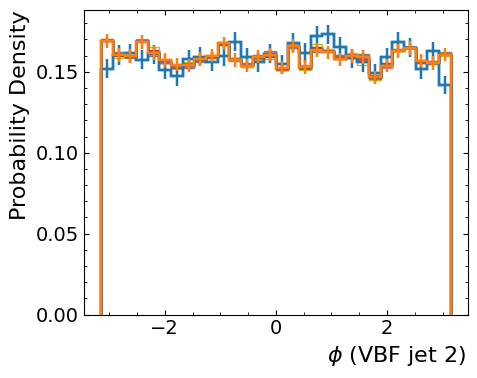

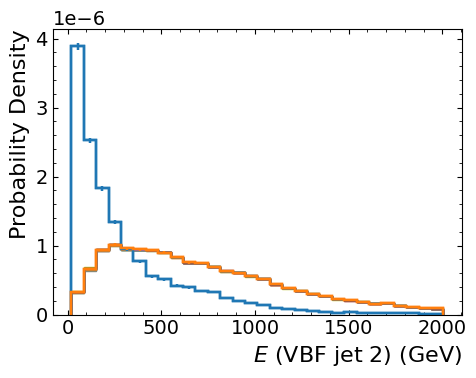

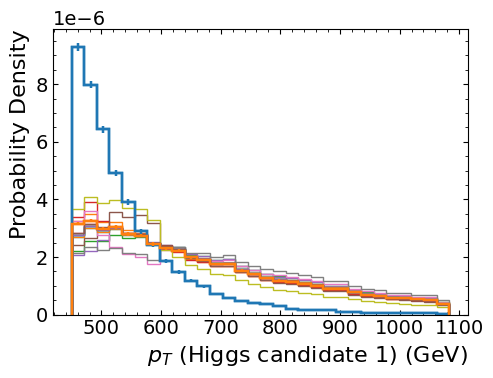

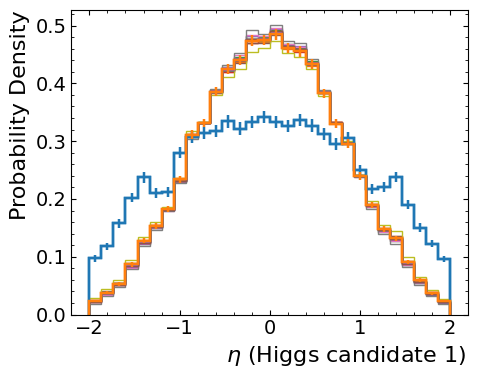

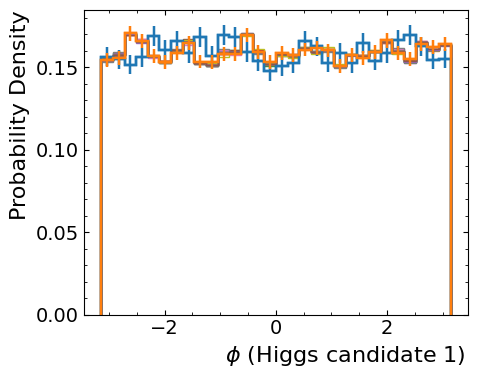

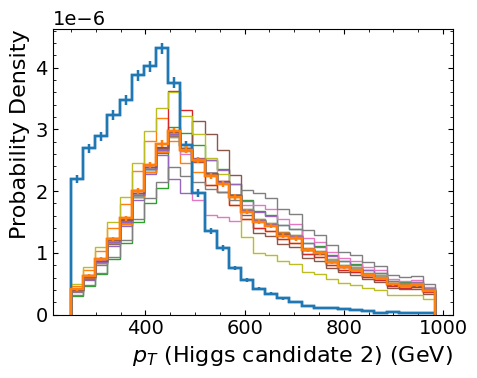

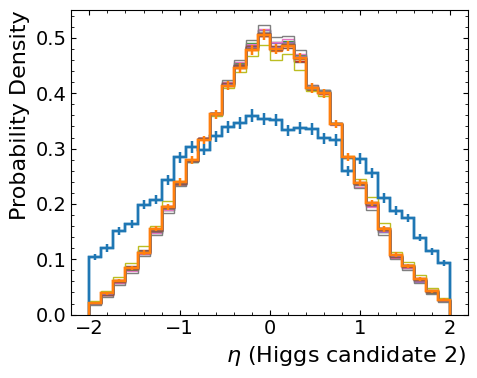

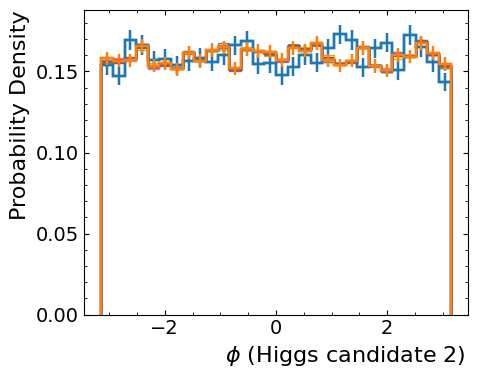

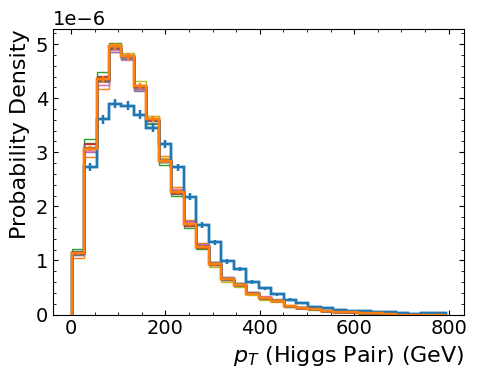

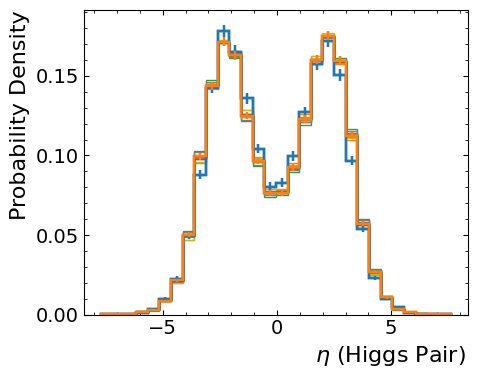

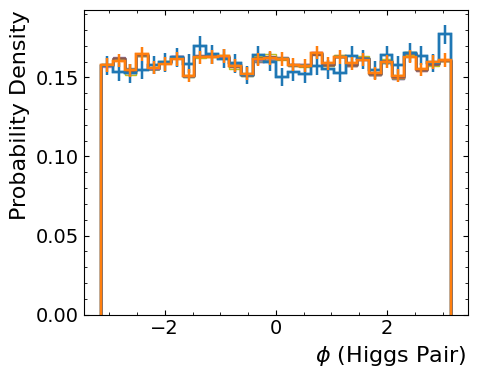

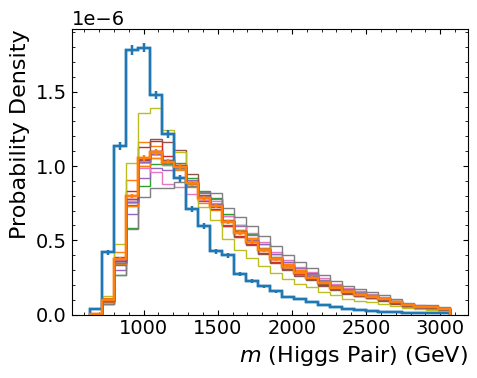

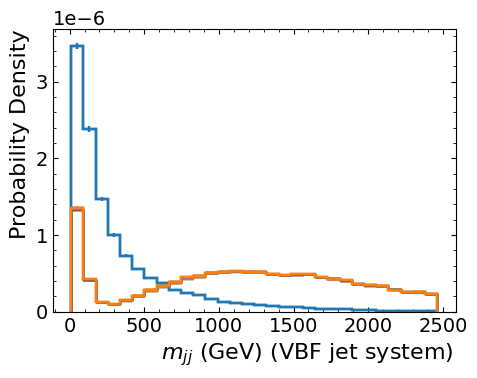

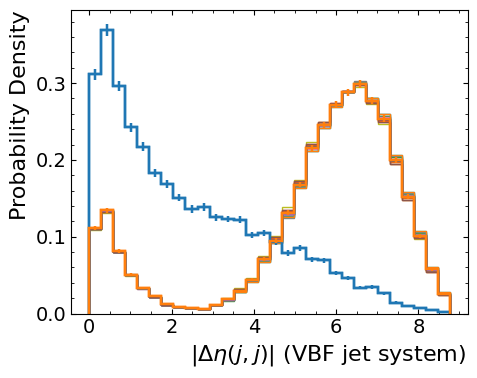

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

plt.rcParams.update({"font.size": 14})

run2_file = (
    "/lustre/fs22/group/atlas/freder/hh/run/dump/tomatos_vars_trigger_sf/dump-run2.h5"
)
signal_file = "/lustre/fs22/group/atlas/freder/hh/run/dump/tomatos_vars_trigger_sf/dump-l1cvv0cv1.h5"


vars = [
    "pt_j1",
    "eta_j1",
    "phi_j1",
    "E_j1",
    "pt_j2",
    "eta_j2",
    "phi_j2",
    "E_j2",
    "pt_h1",
    "eta_h1",
    "phi_h1",
    # "m_h1",
    "pt_h2",
    "eta_h2",
    "phi_h2",
    # "m_h2",
    "pt_hh",
    "eta_hh",
    "phi_hh",
    "m_hh",
    # "lead_xbb_score",
    "m_jj",
    "eta_jj",
]
systematics = [
    "NOSYS",
    "xbb_pt_bin_0__1up",
    "xbb_pt_bin_0__1down",
    "xbb_pt_bin_1__1up",
    "xbb_pt_bin_1__1down",
    "xbb_pt_bin_2__1up",
    "xbb_pt_bin_2__1down",
    "xbb_pt_bin_3__1up",
    "xbb_pt_bin_3__1down",
    "GEN_MUR05_MUF05_PDF260000",
    "GEN_MUR05_MUF10_PDF260000",
    "GEN_MUR10_MUF05_PDF260000",
    "GEN_MUR10_MUF10_PDF260000",
    "GEN_MUR10_MUF20_PDF260000",
    "GEN_MUR20_MUF10_PDF260000",
    "GEN_MUR20_MUF20_PDF260000",
]
labels = [
    "Background Estimate (incl. stat. uncertainty)",
    r"VBF Signal $\kappa_\mathrm{2V}=0$ (incl. stat. uncertainty)",
    "xbb_pt_bin_0__1up",
    "xbb_pt_bin_0__1down",
    "xbb_pt_bin_1__1up",
    "xbb_pt_bin_1__1down",
    "xbb_pt_bin_2__1up",
    "xbb_pt_bin_2__1down",
    "xbb_pt_bin_3__1up",
    "xbb_pt_bin_3__1down",
    "GEN_MUR05_MUF05_PDF260000",
    "GEN_MUR05_MUF10_PDF260000",
    "GEN_MUR10_MUF05_PDF260000",
    "GEN_MUR10_MUF10_PDF260000",
    "GEN_MUR10_MUF20_PDF260000",
    "GEN_MUR20_MUF10_PDF260000",
    "GEN_MUR20_MUF20_PDF260000",
]

std_outliers = 5


def get_density_errors(data, bins):
    # Create the histogram with density=False to get the counts and bin edges
    counts, bin_edges = np.histogram(data, bins)

    # Calculate the width of each bin
    bin_widths = np.diff(bin_edges)

    # Calculate the Poisson errors
    poisson_errors = np.sqrt(counts)

    # Normalize the counts and errors to get the density
    density = counts / (counts.sum() * bin_widths)
    density_errors = poisson_errors / (counts.sum() * bin_widths)

    # Calculate the bin centers for plotting error bars
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    return density, density_errors, bin_centers


with h5py.File(signal_file, "r") as f:
    with h5py.File(run2_file, "r") as run2:
        for v in vars:
            bins = 30
            fig = plt.figure(figsize=(5, 4))

            ########################## bkg hist ###################

            var = f"{v}_NOSYS.SR_xbb_1"
            removed_outliers = run2[var][
                (np.abs(scipy.stats.zscore(run2[var])) < std_outliers)
            ]
            density, density_errors, bin_centers = get_density_errors(
                removed_outliers, bins
            )
            # Plot the histogram with density=True
            bkh_hist, bins, _ = plt.hist(
                removed_outliers,
                density=True,
                bins=bins,
                histtype="step",
                linewidth=1.75,
                color="tab:blue",
            )
            # Plot the error bars
            plt.errorbar(
                bin_centers,
                density,
                yerr=density_errors,
                fmt="none",
                color="tab:blue",
                label="Poisson errors",
            )

            ################## signal hist ####################
            var = f"{v}_NOSYS.SR_xbb_2"
            removed_outliers = f[var][
                (np.abs(scipy.stats.zscore(f[var])) < std_outliers)
            ]
            density, density_errors, bin_centers = get_density_errors(
                removed_outliers, bins
            )

            plt.hist(
                removed_outliers,
                density=True,
                bins=bins,
                histtype="step",
                linewidth=1.75,
                color="tab:orange",
            )

            # Plot the error bars
            plt.errorbar(
                bin_centers,
                density,
                yerr=density_errors,
                fmt="none",
                color="tab:orange",
                label="Poisson errors",
            )

            ################## signal systematics
            for sys in systematics:
                var = f"{v}_{sys}.SR_xbb_2"
                if f"weights_{sys}.SR_xbb_2" in f.keys():
                    w = f"weights_{sys}.SR_xbb_2"
                else:
                    w = f"weights_NOSYS.SR_xbb_2"
                # print(var)
                # print( f[var].shape)
                selection = np.abs(scipy.stats.zscore(f[var])) < std_outliers
                removed_outliers = f[var][selection]
                plt.hist(
                    removed_outliers,
                    weights=f[w][selection],
                    density=True,
                    log=False,
                    bins=bins,
                    histtype="step",
                )

            # # just put bkg and signal on top again
            ########################## bkg hist ###################

            var = f"{v}_NOSYS.SR_xbb_1"
            removed_outliers = run2[var][
                (np.abs(scipy.stats.zscore(run2[var])) < std_outliers)
            ]
            density, density_errors, bin_centers = get_density_errors(
                removed_outliers, bins
            )
            # Plot the histogram with density=True
            bkh_hist, bins, _ = plt.hist(
                removed_outliers,
                density=True,
                bins=bins,
                histtype="step",
                linewidth=1.75,
                color="tab:blue",
            )
            # Plot the error bars
            plt.errorbar(
                bin_centers,
                density,
                yerr=density_errors,
                fmt="none",
                color="tab:blue",
                label="Poisson errors",
                elinewidth=1.75,
            )

            ################## signal hist ####################
            var = f"{v}_NOSYS.SR_xbb_2"
            removed_outliers = f[var][
                (np.abs(scipy.stats.zscore(f[var])) < std_outliers)
            ]
            density, density_errors, bin_centers = get_density_errors(
                removed_outliers, bins
            )

            plt.hist(
                removed_outliers,
                density=True,
                bins=bins,
                histtype="step",
                linewidth=1.75,
                color="tab:orange",
            )

            # Plot the error bars
            plt.errorbar(
                bin_centers,
                density,
                yerr=density_errors,
                fmt="none",
                color="tab:orange",
                label="Poisson errors",
                elinewidth=1.75,
            )

            def get_label(v):
                v_list = v.split("_")
                if "xbb" in v:
                    return "Leading GN2X Score"
                if v_list[1] == "j1":
                    kin_object = "VBF jet 1"
                if v_list[1] == "j2":
                    kin_object = "VBF jet 2"
                if v_list[1] == "h1":
                    kin_object = "Higgs candidate 1"
                if v_list[1] == "h2":
                    kin_object = "Higgs candidate 2"
                if v_list[1] == "hh":
                    kin_object = "Higgs Pair"
                if v_list[1] == "jj":
                    kin_object = "VBF jet system"

                if "pt" in v:
                    variable_ = rf"$p_T$"
                    suffix = "(GeV)"
                if "E" in v:
                    variable_ = rf"$E$"
                    suffix = "(GeV)"
                if "m" in v:
                    variable_ = rf"$m$"
                    suffix = "(GeV)"
                if "phi" in v:
                    variable_ = rf"$\phi$"
                    suffix = ""
                if "eta" in v:
                    variable_ = rf"$\eta$"
                    suffix = ""
                if "m_jj" in v:
                    variable_ = r"$m_{jj}$ (GeV)"
                    suffix = ""
                if "eta_jj" in v:
                    variable_ = r"$|\Delta\eta(j,j)|$"
                    suffix = ""

                return variable_ + " (" + kin_object + ") " + suffix

            plt.xlabel(
                get_label(v),
                loc="right",
                # labelpad=0.9,
                fontsize=16,
            )
            plt.ylabel(
                "Probability Density",
                fontsize=16,
                loc="top",
            )
            plt.xticks(minor=True)
            plt.yticks()
            plt.minorticks_on()
            ax = plt.gca()

            if "GeV" in ax.get_xlabel():
                from matplotlib.ticker import FuncFormatter
                # Function to rescale the x-ticks
                def rescale_ticks(value, tick_number):
                    return f'{int(value * 1e-3)}'

                # Apply the formatter to the x-axis
                ax.xaxis.set_major_formatter(FuncFormatter(rescale_ticks))
                                
            ax.xaxis.set_ticks_position("both")
            ax.yaxis.set_ticks_position("both")
            ax.tick_params(axis="both", which="both", direction="in")  # Ticks inside
            plt.gca().get_xaxis().get_offset_text().set_position((1.12, 0))

            # plt.legend(labels, fontsize=5)

            plt.tight_layout()

            plt.savefig(
                f"/lustre/fs22/group/atlas/freder/hh/run/plots/tomatos_inputs/{var}.pdf"
                # f"/lustre/fs22/group/atlas/freder/hh/run/plots/tomatos_inputs/with_legend/{var}.pdf"
            )

            plt.show()
            plt.close()

In [5]:
# make blank

fig = plt.figure(figsize=(8, 7))
plt.savefig("/lustre/fs22/group/atlas/freder/hh/run/plots/tomatos_inputs/blank.pdf")

<Figure size 800x700 with 0 Axes>